In [2]:
!pip install fastbook
import fastbook
from fastbook import *

     |████████████████████████████████| 727kB 3.5MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 358kB 14.0MB/s 
     |████████████████████████████████| 1.0MB 16.5MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 40kB 5.1MB/s 
     |████████████████████████████████| 92kB 7.7MB/s 
     |████████████████████████████████| 40kB 5.3MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 2.6MB 21.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [5]:
from fastai.vision.all import *

Deep learning models are not domain specific you can use anythong with anythoing
As long as you know what you are doing. in this case what we will do is image regression. We will be using face center prediction.

In [8]:
path = untar_data(URLs.BIWI_HEAD_POSE)


In [10]:
path.ls().sorted()

(#50) [Path('/root/.fastai/data/biwi_head_pose/01'),Path('/root/.fastai/data/biwi_head_pose/01.obj'),Path('/root/.fastai/data/biwi_head_pose/02'),Path('/root/.fastai/data/biwi_head_pose/02.obj'),Path('/root/.fastai/data/biwi_head_pose/03'),Path('/root/.fastai/data/biwi_head_pose/03.obj'),Path('/root/.fastai/data/biwi_head_pose/04'),Path('/root/.fastai/data/biwi_head_pose/04.obj'),Path('/root/.fastai/data/biwi_head_pose/05'),Path('/root/.fastai/data/biwi_head_pose/05.obj')...]

In [11]:
(path/'01').ls().sorted()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/depth.cal'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

In [12]:
img_files = get_image_files(path)

In [13]:
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/18/frame_00657_pose.txt')

In [14]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

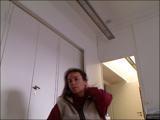

In [15]:
im.to_thumb(160)

In [16]:
# the biwi function to extract the center point

cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [17]:
get_ctr(img_files[0])

tensor([317.7693, 323.0642])

We can pass this function to DataBlock as get_y, since it is responsible for labeling each item. We'll resize the images to half their input size, just to speed up training a bit.

One important point to note is that we should not just use a random splitter. The reason for this is that the same people appears in multiple images in this dataset, but we want to ensure that our model can generalize to people that it hasn't seen yet. Each folder in the dataset contains the images for one person. Therefore, we can create a splitter function that returns true for just one person, resulting in a validation set containing just that person's images.

The only other difference tfrom the previous data block examples is that the second block is a PointBlock. This is necessary so that fastai knows that the labels represent coordinates; that way, it knows that when doing data augmentation, it should do the same augmentation to these coordinates as it does to the images:

In [21]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

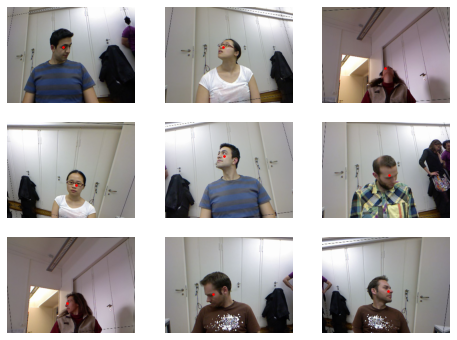

In [22]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

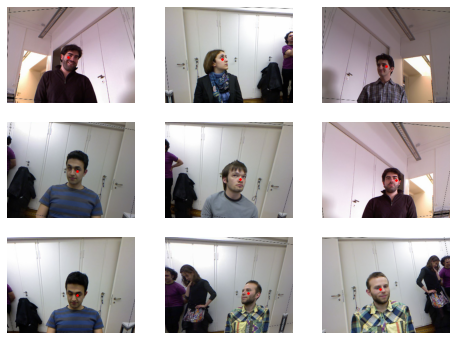

In [23]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [24]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [25]:
yb[0]

tensor([[0.1939, 0.1354]])

In [27]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [28]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

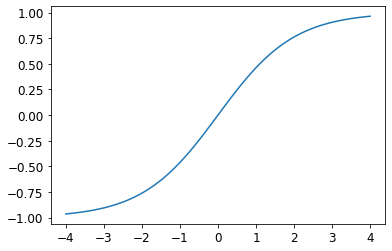

In [29]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [30]:
dls.loss_func

FlattenedLoss of MSELoss()

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-2
learn.fine_tune(3, lr)

In [ ]:
math.sqrt(0.0001)

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))